In [4]:
import pandas as pd
from src.new.newtests import test_speeds, sprinkler_pts, test_joint_prob

from src.networks.dn import StateType, ActionType, ObservationType, RewardType
from src.rl_algorithms.pomdp_lookahead import build_tree, pomdp_lookahead
from src.networks.qbn import QuantumBayesianNetwork as QBN
from src.networks.bn import BayesianNetwork as BN
from src.networks.ddn import DDNFactory as DDN
from src.utils import get_avg_reward_and_std
from src.networks.nodes import DiscreteNode
import matplotlib.pyplot as plt
from src.trees.tree import Tree
import numpy as np

# Code changes

The new updates fix the quantum circuits and replace the QSearch with a calculation of the probability of the evidence P(E) to calculate the optimal number of Grover iterations for the circuit. 

Additionally, a qiskitless version is created by calculating the Grover circuit probabilities analytically and adding shot noise. 

This allows for much faster execution of the algorithms.

This notebook illustrates the changes and main additions, using a simple example (cloudy-sprinkler-rain-wetgrass).

## Speed comparison

In [4]:
test_speeds(Nruns = 10, Nsamples = 10)

> Testing speed for quantum Bayesian network queries.
* Old code
> Time elapsed: 0.10338221189996694ms.
  (To be used as reference.)
* New code
> Time elapsed: 0.012964831400022376ms.
  (8.0x faster than the reference.)
* New (no Qiskit) code
> Time elapsed: 0.001974662199965678ms.
  (52.4x faster than the reference.)


The speed-up is largely enabled by the calculation of the joint probability P(e) from data structures we have access to (CPTs and topological order). P(e) is the amplitude; using it, we can calculate the optimal number of Grover iterations, dispensing with the exponential QSearch and using a fixed circuit. Furthermore, this allows us to simulate the quantum sampling classically, because we can calculate the amplified success rate (lower rejection). We can then forgo Qiskit.   

## Joint probability calculation

Let's consider the sprinkler example.



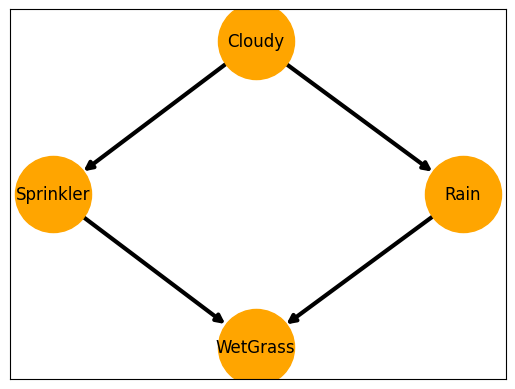

In [1]:
from src.new.newtests import init_problem_bn

bn = init_problem_bn()
bn.draw()

The CPTS we have are $P(C)$, $P(S|C)$, $P(R|C)$, $P(W|S,R)$. 

In [4]:
def print_cpts(cpts_dict):
    for name in cpts_dict.keys():
        a = name[0]
        d = cpts_dict[name]
        parents = [p[0] for p in d.keys() if p != "Prob" and p!=name]
        cond = ("|" + ",".join(parents)) if len(parents)>0 else ""
        print(f"*P({a}{cond}):")
        df = pd.DataFrame(d)
        print(df)

d = sprinkler_pts(simpler = False)
print_cpts(d)

*P(C):
   Cloudy  Prob
0       0   0.5
1       1   0.5
*P(S|C):
   Cloudy  Sprinkler  Prob
0       0          0   0.5
1       0          1   0.5
2       1          0   0.9
3       1          1   0.1
*P(R|C):
   Cloudy  Rain  Prob
0       0     0   0.8
1       0     1   0.2
2       1     0   0.2
3       1     1   0.8
*P(W|S,R):
   Sprinkler  Rain  WetGrass  Prob
0          0     0         0  1.00
1          0     0         1  0.00
2          0     1         0  0.10
3          0     1         1  0.90
4          1     0         0  0.10
5          1     0         1  0.90
6          1     1         0  0.01
7          1     1         1  0.99


The most complicated case where we have to calculate joint probabilities is when some variables are not specified. 

For instance, $P(C = 1, R = 1, S = 1, W = 0)$ is straightforward. We can use:


$$P(x_1, \dots, x_N) = \prod_N P(x_i | parents(X_i))$$

But for joint probabilities like $P(C = 1, R = 1, W = 0)$, we must marginalize over the variable that is not present. We cannot calculate $$P(C=1)P(R=1|C=1)P(W=0|R=1,C=1)$$ because we don't have $P(W|C,R)$, only $P(W|S,R)$. So we have to sum over values of the absent variable(s):

$$P(C = 1, R = 1, W = 0) = \sum_{s \in \{0,1\}} P(C=1)P(R=1|C=1)P(W=0|R=1,S=s)P(S=s|C=1)$$

$$ = 0.5 \times 0.8 \times (0.9 \times 0.1 + 0.1 \times 0.01) = 0.364

In [5]:
ev = {"Cloudy": 1, "Rain": 1, "WetGrass": 0}
test_joint_prob(ev)

Sprinkler
Calculated joint probability: 0.03640000000000001


We create a function that calculates the joint probability of an arbitrary subset of variables given the topological order and the CPTs (both of which we have). 

We have to multiply the conditional probabilities of each node and multiply them. To calculate the conditional probability of a node:
* If there are no unspecified parents, look up the CPT.
* If there are, pick the unspecified parent that is highest in the topological order. Calculate the conditional probability of this parent P given all the other specified variables, for each of its possible values.
* Recursively multiply these probabilities for each value of P by the conditional probability of the original node assuming the value for P. 
* This won't terminate if there is more than one parent for each node. So we only consider a parent as unspecified if there hasn't already been a specified parent that was at the same level or higher in the topological order. Any possible path should give the same result if the probability distribution is correct.

# Running numerical tests 

## Tiger Problem

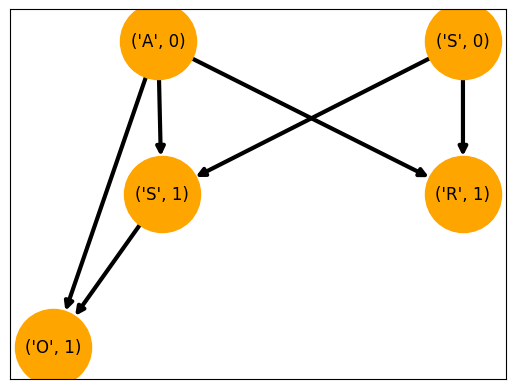

In [7]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=StateType, value_space=[0, 1])
a0 = DiscreteNode(("A", 0), node_type=ActionType, value_space=[0, 1, 2])
s1 = DiscreteNode(("S", 1), node_type=StateType, value_space=[0, 1])
o1 = DiscreteNode(("O", 1), node_type=ObservationType, value_space=[0, 1])
r1 = DiscreteNode(("R", 1), node_type=RewardType, value_space=[-100, -1, 10])

# Settings for the POMDP
discount = 0.8
nodes = [s0, s1, o1, r1, a0]
edges = [
    (("S", 0), ("S", 1)),
    (("S", 0), ("R", 1)),
    (("A", 0), ("S", 1)), 
    (("A", 0), ("R", 1)), 
    (("A", 0), ("O", 1)), 
    (("S", 1), ("O", 1)) 
]

# Create the DDN structure
ddn = DDN(BN)(discount=discount)
ddn.add_nodes(nodes)
ddn.add_edges(edges)
ddn.draw()

# Create quantum DDN
qddn = DDN(QBN)(discount=discount)
qddn.add_nodes(nodes)
qddn.add_edges(edges)

# Adding CPTs

# Add data for node State 0
data = {
    ("S", 0): [0,1], 
    "Prob": [0.5,0.5]
}
ddn.add_pt(("S", 0), data)
qddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,1,1,1,1,1,1], 
    ("A", 0): [0,0,1,1,2,2,0,0,1,1,2,2], 
    ("S", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [1,0,0.5,0.5,0.5,0.5,0,1,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("S", 1), data)
qddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = {
    ("A", 0): [0,0,0,0,1,1,1,1,2,2,2,2], 
    ("S", 1): [0,0,1,1,0,0,1,1,0,0,1,1], 
    ("O", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [0.85,0.15,0.15,0.85,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("O", 1), data)
qddn.add_pt(("O", 1), data)

# Add data for node Reward
data = {
    ("A", 0): [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2], 
    ("S", 0): [0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1], 
    ("R", 1): [-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10], 
    "Prob": [0.05,0.9,0.05,0.05,0.9,0.05,0.9,0.05,0.05,0.05,0.05,0.9,0.05,0.05,0.9,0.9,0.05,0.05]
}
ddn.add_pt(("R", 1), data)
qddn.add_pt(("R", 1), data)

# Initialize ddn
ddn.initialize()
qddn.initialize()

## Robot search

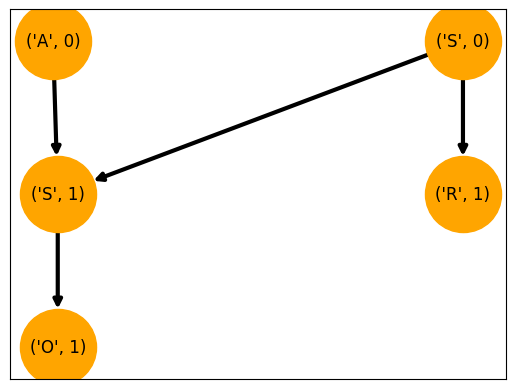

In [10]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=StateType, value_space=[0,1,2,3])
a0 = DiscreteNode(("A", 0), node_type=ActionType, value_space=[0,1])
s1 = DiscreteNode(("S", 1), node_type=StateType, value_space=[0,1,2,3])
o1 = DiscreteNode(("O", 1), node_type=ObservationType, value_space=[0,1])
r1 = DiscreteNode(("R", 1), node_type=RewardType, value_space=[0,1])

# Settings for the POMDP
discount = 0.8
nodes = [s0, s1, o1, r1, a0]
edges = [
    (("S", 0), ("S", 1)),
    (("S", 0), ("R", 1)), 
    (("A", 0), ("S", 1)),
    (("S", 1), ("O", 1))
]

# Create the DDN structure
robot_ddn = DDN(BN)(discount=discount)
robot_ddn.add_nodes(nodes)
robot_ddn.add_edges(edges)
robot_ddn.draw()

# Create quantum DDN structure
robot_qddn = DDN(QBN)(discount=discount)
robot_qddn.add_nodes(nodes)
robot_qddn.add_edges(edges)

# Add data for node State 0
data = {
    ("S", 0): [0,1,2,3], 
    "Prob": [0.25,0.25,0.25,0.25]
}
robot_ddn.add_pt(("S", 0), data)
robot_qddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3], 
    ("A", 0): [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1], 
    ("S", 1): [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3], 
    "Prob": [0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1/3,1/3,0,1/3,1/3,1/3,0,1/3,0,0,1,0,1,0,0,0]
}
robot_ddn.add_pt(("S", 1), data)
robot_qddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = { 
    ("S", 1): [0,0,1,1,2,2,3,3], 
    ("O", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [0.7,0.3,0.7,0.3,0.3,0.7,0.7,0.3]
}
robot_ddn.add_pt(("O", 1), data)
robot_qddn.add_pt(("O", 1), data)

# Add data for node Reward
data = { 
    ("S", 0): [0,0,1,1,2,2,3,3], 
    ("R", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [0.8,0.2,0.8,0.2,0.2,0.8,0.8,0.2]
}
robot_ddn.add_pt(("R", 1), data)
robot_qddn.add_pt(("R", 1), data)

# Initialize ddn
robot_ddn.initialize()
robot_qddn.initialize()

# Function for getting performance metrics

In [11]:
def get_metrics(ddn, qddn, tree, classical_samples, quantum_samples, reward_samples, time, verbose=True):
    # Calculate metrics for the time-steps
    c_avg_r, c_std = [], []
    q_avg_r, q_std = [], []

    for t in range(time):

        # Classical results
        actions = pomdp_lookahead(ddn, tree, classical_samples)
        avg, std = get_avg_reward_and_std(ddn, ("R", 1), {**actions, **ddn.get_belief_state()}, reward_samples)
        observations = ddn.sample_observation(actions)
        ddn.belief_update(actions, observations, classical_samples)

        # Append results
        c_avg_r.append(avg)
        c_std.append(std)

        # Print info
        if verbose:
            print(f"\nClassical | Time-step: {t} | Exp Reward: {avg:.3f} | Std: {std:.3f}")

        # Quantum results
        actions = pomdp_lookahead(qddn, tree, quantum_samples)
        avg, std = get_avg_reward_and_std(ddn, ("R", 1), {**actions, **qddn.get_belief_state()}, reward_samples)
        observations = ddn.sample_observation(actions)
        qddn.belief_update(actions, observations, quantum_samples)

        # Append results
        q_avg_r.append(avg)
        q_std.append(std)

        # Print info
        if verbose:
            print(f"Quantum | Time-step: {t} | Exp Reward: {avg:.3f} | Std: {std:.3f}")
        
    c_avg_r, c_std = np.array(c_avg_r), np.array(c_std)
    q_avg_r, q_std = np.array(q_avg_r), np.array(q_std)
    
    return c_avg_r, c_std, q_avg_r, q_std

In [ ]:
# Hyperparameters for obtaining results
time = 100
reward_samples = 1000
classical_samples = 10
quantum_samples = int(np.ceil(classical_samples**2))

# Get metrics
c_avg_r, c_std, q_avg_r, q_std = get_metrics(ddn, qddn, tree, classical_samples, quantum_samples, reward_samples, time)

# Get cummulative rewards and standard deviations
c_cum_r, q_cum_r = np.cumsum(c_avg_r), np.cumsum(q_avg_r)
c_cum_std, q_cum_std = np.sqrt(np.cumsum(np.array(c_std)**2)), np.sqrt(np.cumsum(np.array(q_std)**2))

# Parameters for the plot
textstr = f"$H = {horizon}$"
textstr += f"\n$\gamma={discount}$"
textstr += f"\nClassical samples={classical_samples}"
textstr += f"\nQuantum samples={quantum_samples}"
# figname = input("What do you want to name your figure: ")
figname = "TigerProblemH2"

# Making the plot
plt.title("Cumulative reward over time")
plt.xlabel("Time-step $t$")
plt.ylabel("Cumulative reward")
plt.plot(range(time), c_cum_r, label="classic")
plt.fill_between(range(time), c_cum_r-c_cum_std, c_cum_r+c_cum_std, alpha=0.2)
plt.plot(range(time), q_cum_r, label="quantum")
plt.fill_between(range(time), q_cum_r-q_cum_std, q_cum_r+q_cum_std, alpha=0.2)
plt.gcf().text(0.95, 0.7, textstr, fontsize=10)
plt.legend()
# plt.savefig(f"../plots/{figname}.png", dpi=250, bbox_inches="tight")
plt.show()

In [ ]:
# Calculate cumulative difference avg and std
cum_diff_avg, cum_diff_std = q_cum_r - c_cum_r, np.sqrt(np.cumsum((q_std - c_std)**2))

# Plot the differences
plt.title("Cumulative reward difference over time")
plt.xlabel("Time-step $t$")
plt.ylabel("Cumulative reward difference")
plt.plot(range(time), cum_diff_avg)
plt.fill_between(range(time), cum_diff_avg-cum_diff_std, cum_diff_avg+cum_diff_std, alpha=0.2)
plt.gcf().text(0.95, 0.7, textstr, fontsize=10)
# plt.savefig(f"../plots/{figname}Difference.png", dpi=250, bbox_inches="tight")
plt.show()

Dataframes are saved into csv files, e.g.

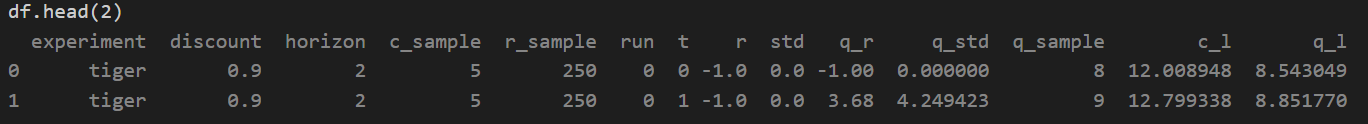

A run is executed for all intended times, then another, etc. so as to average. 

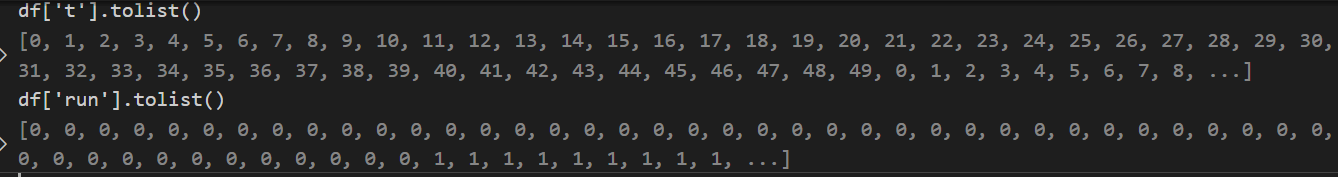

cum_diff_avg, cum_diff_std = q_cum_r - c_cum_r, np.sqrt(np.cumsum((q_std - c_std)**2))